In [66]:
import pandas as pd
import csv
import numpy as np
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix

from google.colab import drive
drive.mount('/content/gdrive')


home_dir = "/content/gdrive/MyDrive/Colab Notebooks/COMP_551Assignment2/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



1. Implement and evaluate Logistic Regression on the IMDB data
2. Implementing and evaluate the Multiclass Regression on the 4-class prediction from the 20-news-group data

# Implement and evaluate Logistic Regression on the IMDB data

## Data Processing on IMDB Reviews data

###  filter out words

*   labeledBow.feat: 

rating_for_review0 (word_indice0:frequency0),(word_indice1:frequency1),...

rating_for_review1 (word_indice0:frequency0),(word_indice1:frequency1),...

...

*  imdb.vocab:

all our features

In [67]:
'''load data'''
data_dir = home_dir + "aclImdb/train/labeledBow.feat"
X,Y = load_svmlight_file(data_dir, multilabel = False, zero_based = True)
# print(X[:,1]) # :,n -> nth feature in all reviews

# print(type(X))
'''group by features and get occurences'''
ind = X.indices
ind_series = pd.Series(ind, name='index')
ind_gp = ind_series.groupby(lambda x: ind_series[x])
ind_gp_df = ind_gp.count().to_frame(name='occurence')
ind_gp_df.insert(loc=0, column='feature', value=np.arange(len(ind_gp_df)))
#ind_gp_df
Y

array([9., 7., 9., ..., 4., 2., 2.])

In [68]:
'''filter by occurence'''
filtered = ind_gp_df[(ind_gp_df['occurence'] > 250) & (ind_gp_df['occurence'] < 12500)]
indices = filtered['feature'].values
indices
# print(type(indices))

array([  21,   23,   27, ..., 1933, 1935, 1938])

### choose the top D

z = x^T * y / (sqrt(N))

In [69]:
Y_new = (pd.DataFrame(Y)).to_numpy()[:,0].copy()
for i in range(len(Y_new)):
  if Y_new[i]>=7:
    Y_new[i]=1
  else:
    Y_new[i]=0
print(Y_new)
print(Y)

[1. 1. 1. ... 0. 0. 0.]
[9. 7. 9. ... 4. 2. 2.]


In [70]:
from pandas.core.construction import array
from numpy.lib.shape_base import tile
from numpy.lib.index_tricks import s_
from numpy.core.fromnumeric import std
from sklearn.preprocessing import StandardScaler

N=25000
x_new = X[:,indices].toarray()
x_new_standardize = StandardScaler().fit(x_new).transform(x_new)

z1 = np.matmul(x_new_standardize.transpose(), Y_new)/np.sqrt(N)

#find the absolute value of all z-score 
z1_absolute = np.absolute(z1)
# x_new_average = np.mean(x_new_standardize)
# z1_average = np.mean(z1_absolute)
# z1_std = np.std(z1_absolute)
# z1_range = z1_std + z1_average
# z1_index = np.where((z1_absolute >= z1_average) & (z1_absolute <=z1_range))[0]
z1_index_top100 = np.argsort(z1_absolute)[0:500]


Data preprocessing
turn the text data into tabular format with selected features as the words and the text documents as the training or test examples.


##1. Logistic Regression

In [71]:

%matplotlib notebook
%matplotlib inline
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [72]:
import itertools
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

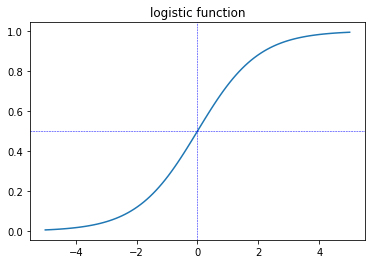

In [73]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-5,5,100)
plt.plot(z, logistic(z))
plt.axhline(y = 0.5, color = 'b', linestyle = 'dashed', lw=0.5)
plt.axvline(x = 0, color = 'b', linestyle = 'dashed', lw=0.5)
plt.title('logistic function')
plt.savefig('logistic_function.png', bbox_inches="tight", dpi=300)

###Logistic Regression

In [74]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.ce_history = []

    def gradient(self, x, y):
        N,D = x.shape
        a = np.dot(x, self.w)
        yh = logistic(np.dot(x, self.w))    # predictions  size N

        self.ce_history.append(np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))))

        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1

            #--------------------------------
            # self.gradient_hist.append(g)
            #--------------------------------
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

# LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

###Final Dataframe

training dataset

In [75]:
from pandas.core.internals.construction import to_arrays
# sort_topD_z_score_index = np.array(topD_z_score_index)
array_X = np.array(X)
df = pd.DataFrame.sparse.from_spmatrix(X)
# df1 is the dataframe of X
X_train = df.iloc[:,z1_index_top100].to_numpy()
X_train = StandardScaler().fit(X_train).transform(X_train)
# print(df1.shape)
# X_train = df1.sort_index(axis=1).to_numpy()
#df2 is the dataframe of Y

Y_train = (pd.DataFrame(Y)).to_numpy()[:,0].copy()
for i in range(len(Y_train)):
  if Y_train[i]>=7:
    Y_train[i]=1
  else:
    Y_train[i]=0
Y_train


array([1., 1., 1., ..., 0., 0., 0.])

test dataset

In [76]:
test_data_dir =  home_dir + "aclImdb/test/labeledBow.feat"
XT,YT = load_svmlight_file(test_data_dir, multilabel = False, zero_based = True)
df_Test = pd.DataFrame.sparse.from_spmatrix(XT)
X_test = df_Test.iloc[:,z1_index_top100].to_numpy()
# X_test = dfX_Test.sort_index(axis=1).to_numpy()
X_test = StandardScaler().fit(X_test).transform(X_test)
Y_test = (pd.DataFrame(YT)).to_numpy()[:,0].copy()
for i in range(len(Y_test)):
  if Y_test[i]>=7:
    Y_test[i]=1
  else:
    Y_test[i]=0
Y_test
#X_test.headers(50)

array([1., 1., 1., ..., 0., 0., 0.])

###Classification accuracy

In [83]:
'''re-allocate samples'''
X_split1 = X_train[0:6250,:]
X_split2 = X_train[18750:25000,:]
X_train_cat = np.concatenate((X_split1, X_split2), axis=0) # re-sliced x train

Y_split1 = Y_train[0:6250]
Y_split2 = Y_train[18750:25000]
Y_train_cat = np.concatenate((Y_split1,Y_split2), axis=0) # re-sliced y train

X_val = X_train[6250:18750,:]
Y_val = Y_train[6250:18750]

'''validate laerning rate'''
logitreg2 = LogisticRegression(max_iters=1e3)
fit = logitreg2.fit(X_train_cat, Y_train_cat)

y_train_pred = fit.predict(X_train_cat)
y_test_pred = fit.predict(X_val)

# threshold probabilities
y_train_pred = (y_train_pred > 0.5).astype(int)
y_test_pred = (y_test_pred > 0.5).astype(int)

# accuracy = correctly classified / total classified
acc_train = sum(y_train_pred==Y_train_cat)/len(Y_train_cat)
acc_test = sum(y_test_pred==Y_val)/len(Y_val)
print(f"train accuracy: {acc_train:.7f}; test accuracy: {acc_test:.7f}")


train accuracy: 0.7901600; test accuracy: 0.7409600


through experiments we found best alpha=0.1

In [78]:
'''test sample'''
from numpy.lib.function_base import gradient
logitreg = LogisticRegression(max_iters=1e3)
fit = logitreg.fit(X_train_cat, Y_train_cat)

weights = fit.w
y_train_pred = fit.predict(X_train_cat)
y_test_pred = fit.predict(X_test)

# threshold probabilities
y_train_pred = (y_train_pred > 0.5).astype(int)
y_test_pred = (y_test_pred > 0.5).astype(int)

# accuracy = correctly classified / total classified
acc_train = sum(y_train_pred==Y_train_cat)/len(Y_train_cat)
acc_test = sum(y_test_pred==Y_test)/len(Y_test)
print(f"train accuracy: {acc_train:.7f}; test accuracy: {acc_test:.7f}")

train accuracy: 0.7901600; test accuracy: 0.7528800


### Check gradient 
1. small perturbation

1. $\epsilon \sim Uniform([0,1])$
2. $w^{(+)}_d = w_d + \epsilon$
3. $w^{(-)}_d = w_d - \epsilon$
4. $\nabla w_d = \frac{J(w^{(+)}_d) - J(w^{(-)}_d)}{2 \epsilon}$ (numerically estimated gradient)
5. $\frac{(\frac{\partial J(w)}{\partial w}  - \nabla w_d)^2}{(\frac{\partial J(w)}{\partial w}  + \nabla w_d)^2}$ must be small (e.g., $10^{-8}$) otherwise your gradient calculation and/or your loss function is incorrect

In [79]:
# N=25000
# x = np.linspace(-5,5, N)
# y = (x > 0.5).astype(int)

x = X_train_cat
y = Y_train_cat

N = x.shape[0]
x = np.column_stack([x,np.ones(N)])

'''small perturbation'''
# w = np.random.randn(1)
# w0 = w

w0 = weights
# print(w0)
# print(len(x))

epsilon = np.random.randn(1)[0] * 1e-5
w1 = w0 + epsilon
w2 = w0 - epsilon
# a1 = w1*x
# a2 = w2*x

a1 = np.matmul(x, w1)
a2 = np.matmul(x, w2)

ce1 = np.sum(y * np.log1p(np.exp(-a1)) + (1-y) * np.log1p(np.exp(a1)))
ce2 = np.sum(y * np.log1p(np.exp(-a2)) + (1-y) * np.log1p(np.exp(a2)))
dw_num = (ce1 - ce2)/(2*epsilon) # approximated gradient

# yh = 1/(1+np.exp(-x * w0))
yh = 1/(1+np.exp(np.matmul(-x, w0)))
dw_cal = np.sum(np.matmul(x.transpose(), (yh - y)) )  # hand calculated gradient

# print(dw_cal)
# print(dw_num)
print((dw_cal - dw_num)**2/(dw_cal + dw_num)**2)

1.7990106514914935e-09


2. Convergence

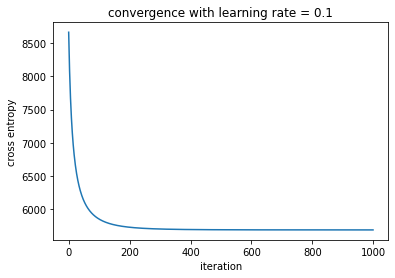

In [80]:
ce_history = logitreg.ce_history
plt.plot(range(len(ce_history)),ce_history)
plt.title('convergence with learning rate = ' + str(logitreg.learning_rate))
plt.ylabel('cross entropy')
plt.xlabel('iteration')
plt.show()

comparing with linear regression

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.api as sm

Y_1 = Y[0:6250]
Y_2 = Y[18750:25000]
Y_train_linear = np.concatenate((Y_1,Y_2), axis=0)
Y_test_linear = (pd.DataFrame(YT)).to_numpy()[:,0].copy()

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X_train_cat, Y_train_linear)

# with statsmodels
X_train_linear = sm.add_constant(X_train_cat) # adding a constant
model = sm.OLS(Y_train_linear, X_train_linear).fit()
predictions = model.predict(X_train_linear) 
print_model = model.summary()

print(print_model)
# mse = mean_squared_error(y_true=Y_test_linear,y_pred=y_pred_lr) #default=True
# print("mse = ", mse)
# r2 = reg.score(X_test, Y_test_linear)
# print("r2 score =", r2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     12.38
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:31:21   Log-Likelihood:                -30729.
No. Observations:               12500   AIC:                         6.246e+04
Df Residuals:                   11999   BIC:                         6.618e+04
Df Model:                         500                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4633      0.026    207.002      0.0

comparing with lasso and ridge

In [85]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

xx = X_train_cat
yy = Y_train_cat

rr = Ridge(alpha=0.01)
rr.fit(xx, yy) 
pred_train_rr = rr.predict(xx)
print(np.sqrt(mean_squared_error(yy,pred_train_rr)))
print(r2_score(yy, pred_train_rr))
print("---------------")
pred_test_rr = rr.predict(X_test)
print(np.sqrt(mean_squared_error(Y_test,pred_test_rr))) 
print(r2_score(Y_test, pred_test_rr))
r2_score_ridge = r2_score(Y_test, pred_test_rr)


0.4072518649869276
0.33658367385867705
---------------
0.42657717680244633
0.27212764892501784


## Plots of Logistic *Regression*

Horizontal Bar

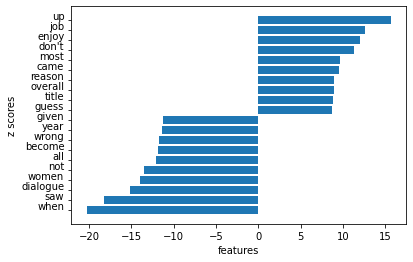

In [86]:
from numpy.core.multiarray import concatenate
import matplotlib.pyplot as plt
z1_sort_index = z1[:].argsort()
z1_sort_index = z1_sort_index.reshape((1734))
z1_top10_neg = z1[z1_sort_index[0:10]]
z1_top10_pos = z1[z1_sort_index[1724:1734]]

z1_top20_X = np.concatenate([z1_top10_neg, z1_top10_pos])
feature_df = pd.DataFrame(open(home_dir + "aclImdb/imdb.vocab","r"))
z1_sort_index_top20 = z1_sort_index[np.r_[0:10,1724:1734]]
feature_top20_Y = feature_df.iloc[z1_sort_index_top20]

plt.barh(list(feature_top20_Y[0]),z1_top20_X)
plt.title('')
plt.ylabel('z scores')
plt.xlabel('features')
plt.show()

ROC curves

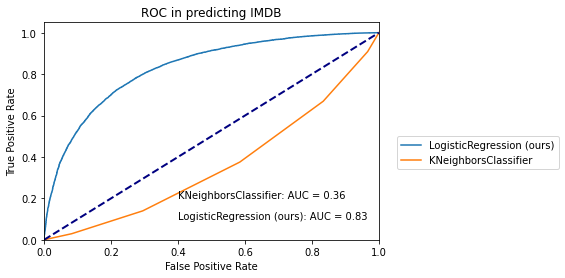

In [87]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

models = [KNeighborsClassifier()]

perf = {}

# our implementation is slow you may try sklearn version
logitreg = LogisticRegression(max_iters=1e3)
fit = logitreg.fit(X_train_cat, Y_train_cat)
y_test_prob = fit.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, y_test_prob)
auroc = roc_auc_score(Y_test, y_test_prob)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit = model.fit(X_train_cat, Y_train_cat)
    y_test_prob = fit.predict_proba(X_test)[:,0]
    fpr, tpr, _ = roc_curve(Y_test, y_test_prob)
    auroc = roc_auc_score(Y_test, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
# plt.close()

AUROC

In [88]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

split_rate = [0.2,0.4,0.6,0.8]
logreg_list = []
KNN_list = []
for i in split_rate:
  AUROC_X_train, AUROC_X_test, AUROC_y_train, AUROC_y_test = train_test_split(X_train, Y_train, train_size=i,test_size=1-i)
  #logistic regression
  logitreg = LogisticRegression(max_iters=1e-3)
  logitreg.fit(AUROC_X_train, AUROC_y_train)
  y_test_prob = logitreg.predict(X_test)


  fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_test_prob)
  # print(metrics.auc(fpr, tpr))
  logreg_list.append(metrics.auc(fpr, tpr))
  #---------------------------------
  #KNN
  KNN_fit = KNeighborsClassifier().fit(AUROC_X_test,AUROC_y_test)
  KNN_y_test_prob = KNN_fit.predict_proba(X_test)[:,0]
  KNN_fpr, KNN_tpr, KNN_thresholds = metrics.roc_curve(Y_test, KNN_y_test_prob)
  KNN_list.append(metrics.auc(KNN_fpr, KNN_tpr))

#when we use 100% data train
split_rate.append(1.0)
logitreg.fit(AUROC_X_train, AUROC_y_train)
y_test_prob = logitreg.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_test_prob)
logreg_list.append(metrics.auc(fpr, tpr))

KNN_fit = KNeighborsClassifier().fit(AUROC_X_test,AUROC_y_test)
KNN_y_test_prob = KNN_fit.predict_proba(X_test)[:,0]
KNN_fpr, KNN_tpr, KNN_thresholds = metrics.roc_curve(Y_test, KNN_y_test_prob)
KNN_list.append(metrics.auc(KNN_fpr, KNN_tpr))



(5, 3)
0    0.818487
1    0.824831
2    0.825372
3    0.823001
4    0.823001
Name: logreg, dtype: float64
0    0.356439
1    0.354101
2    0.353712
3    0.372217
4    0.372217
Name: KNN, dtype: float64


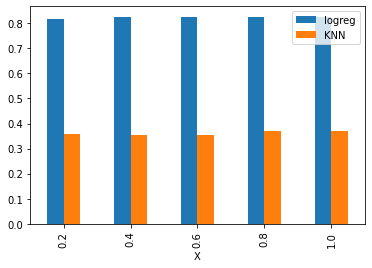

In [89]:
X_axis = ["0.2","0.4","0.6","0.8","1.0"]
AUROC_DF = pd.DataFrame({'logreg':logreg_list,'KNN':KNN_list, "X":X_axis})

print(AUROC_DF.shape)
# AUROC_DF.index = X_axis
# print(AUROC_DF.index)
print(AUROC_DF.loc[:,"logreg"])
print(AUROC_DF.loc[:,"KNN"])
AUROC_DF.plot(x="X", y=["logreg","KNN"],kind="bar")

plt.show()

Horizontal Bar from logistic regression

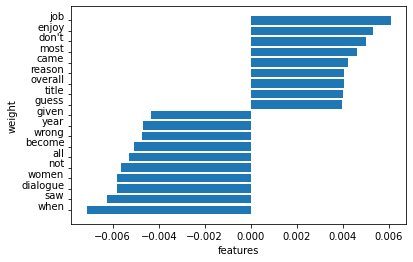

In [90]:
fit_logreg_features = logitreg.fit(X_train, Y_train)
weight = logitreg.w 
weight_sort_index = weight[:].argsort()
weight_sort_index
weight_top10_neg = weight[weight_sort_index[0:10]]
weight_top10_pos = weight[weight_sort_index[-10:-1]]

weight_top20_X = np.concatenate([weight_top10_neg, weight_top10_pos])
feature_df_new = pd.DataFrame(open(home_dir + "aclImdb/imdb.vocab","r"))
weight_sort_index_top20 = z1_sort_index[np.r_[0:10,-10:-1]]
feature_top20_Y_new = feature_df_new.iloc[weight_sort_index_top20]

plt.barh(list(feature_top20_Y_new[0]),weight_top20_X)
plt.title('')
plt.ylabel('weight')
plt.xlabel('features')
plt.show()

# Implement and evaluate Multiclass Regression on the 20 new groups data

## Data Processing on 20 news groups: a multi-class labelled textual dataset




In [91]:
# load data 
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from keras.utils.np_utils import to_categorical  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# fetch 20 newsgroups dataset
categories = [ 'comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']
twenty_train = fetch_20newsgroups(subset='train', remove=(['headers', 'footers', 'quotes']),categories=categories)
twenty_test = fetch_20newsgroups(subset='test', remove=(['headers', 'footers', 'quotes']),categories=categories)

In [92]:

count_vect = CountVectorizer(stop_words='english', min_df=0.01, max_df=0.5)

X_train_counts = count_vect.fit_transform(twenty_train.data)
X_test_counts = count_vect.transform(twenty_test.data)

X_train_counts = X_train_counts.toarray()
X_test_counts = X_test_counts.toarray()

#X_train_counts = preprocessing.scale(X_train_counts)
#X_test_counts = preprocessing.scale(X_test_counts)
X_train_counts = 10*(X_train_counts-np.min(X_train_counts))/(np.max(X_train_counts)-np.min(X_train_counts))
X_test_counts = 10*(X_test_counts-np.min(X_test_counts))/(np.max(X_test_counts)-np.min(X_test_counts))

Y_train = to_categorical(twenty_train.target, num_classes=4)
Y_test = to_categorical(twenty_test.target, num_classes=4)
twenty_train.target

array([2, 3, 0, ..., 2, 1, 3])

In [93]:
from sklearn.metrics import mutual_info_score

'''get selected x train '''
#X_train_array = X_train_counts.toarray() # shape (2257, 28865)
#X_train_selected = X_train_array[:, top_ind]
''' use MI to select features'''

# get one-hot-encoding for 4 y's
num_cat = 20
num_instance, num_feature = X_train_counts.shape
 
Y_array = np.zeros((num_cat, num_instance))

for i in range(0,4):
  Y_array[i] = [row[i] for row in Y_train]

  X_train_t = X_train_counts.transpose()   # x transpose

mi = np.zeros((num_cat, num_feature))

# loop every y 
for i in range(0,4):
      # loop every feature in x
  for k in range(0, np.shape(X_train_t)[0]): 
        
      mi[i][k] = mutual_info_score(X_train_t[k,:] , Y_array[i,:])   # mi score matrix where row is y, col is feature

In [94]:
    
# get top 100 features for each y category
# sort every row of mi matrix

features = []
for i in range(0,4):
  row = mi[i,:]
  row_sorted = np.argsort(row)[::-1]
  row_top = row_sorted[:100]
  features.extend(row_top)

selected_feature = np.unique(features)


## 2. multiclass regresssion

In [95]:

from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn import preprocessing
import random
random.seed(551)

In [96]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.0045, niter=100):
        self.lr = lr
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                #print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            
            #else:
                #print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

Run Experiments

In [97]:
X_train = X_train_counts[:,selected_feature]
X_test = X_test_counts[:,selected_feature]

N, C = Y_train.shape

X_train = np.c_[X_train, np.ones(N)] # add one column to learn the linear intercept

X_test = np.c_[X_test, np.ones(X_test.shape[0])]

D = X_train.shape[1]

In [98]:
mlr = Multinomial_logistic(D, C)
ce_train = mlr.fit(X_train, Y_train, niter=1000)
train_accuracy = evaluate(mlr.predict(X_train), Y_train)

test_accuracy = evaluate(mlr.predict(X_test), Y_test)

print(train_accuracy)
print(test_accuracy)

0.850231384097602
0.7996207332490518


In [ ]:
print(mlr.W)

###check gradient
1. small perturbation

In [99]:
# check grad
print(mlr.check_grad(X_train, Y_train))

2.0008412977688808e-09


2. convergence plot

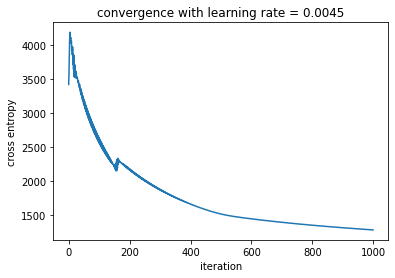

In [100]:
ce_losses = ce_train[0]
# print(ce_losses)
plt.plot(range(len(ce_losses)),ce_losses)
plt.title('convergence with learning rate = ' + str(mlr.lr))
plt.ylabel('cross entropy')
plt.xlabel('iteration')
plt.show()

##plot

Compare result with sklearn multiclass model

In [101]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, twenty_train.target)
clf
clf.score(X_test, twenty_test.target)

0.7553729456384324

HeatMap

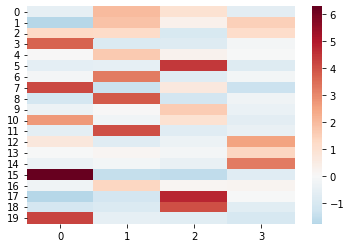

In [102]:
from seaborn import heatmap

# top 5 most positive features for each class
top5_features = []
for i in range(0,4):
  row = mi[i,:]
  row_sorted = np.argsort(row)[::-1]
  row_top = row_sorted[:5]
  top5_features.extend(row_top)

index_in_top100 = []
for elt in top5_features:
  index_in_top100.append(features.index(elt))

W_hat = mlr.W[np.array(index_in_top100)]
hmp = heatmap(W_hat, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

#print(top5_features)
#top5_features

 Compare the accuracy on different training size

In [103]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


split_rate = [0.2, 0.4, 0.6, 0.8]
multiclass_list = []
KNN_list = []


for i in split_rate:
  AUROC_X_train, AUROC_X_test, AUROC_y_train, AUROC_y_test = train_test_split(X_train, Y_train, train_size=i, test_size=1-i)
  N, C = AUROC_y_train.shape
  mlr = Multinomial_logistic(D, C)
  ce_train = mlr.fit(AUROC_X_train, AUROC_y_train, niter=1000)
  print("training size: " + str(i) + "\n number of x uses ")
  print(AUROC_X_train.shape[0])
  accuracy = evaluate(mlr.predict(X_test), Y_test)
  print("accuracy: "+ str(accuracy))
  multiclass_list.append(accuracy)

Y_train_knn = twenty_train.target
Y_test_knn = twenty_test.target

for j in split_rate:

  AUROC_X_train, AUROC_X_test, AUROC_y_train, AUROC_y_test = train_test_split(X_train, Y_train_knn, train_size=j, test_size=1-j)
  knn = KNeighborsClassifier(n_neighbors=3)
  knn.fit(AUROC_X_train, AUROC_y_train)

  y_pred = knn.predict(X_test)

  KNN_list.append(accuracy_score(Y_test_knn, y_pred))

# train size = 1.0
split_rate.append(1.0)
mlr = Multinomial_logistic(D, C)
ce_train = mlr.fit(X_train, Y_train, niter=1000)
multiclass_list.append(evaluate(mlr.predict(X_test), Y_test))

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train_knn)
y_pred = knn.predict(X_test)
KNN_list.append(accuracy_score(Y_test_knn, y_pred))



training size: 0.2
 number of x uses 
475
accuracy: 0.7579013906447535
training size: 0.4
 number of x uses 
950
accuracy: 0.7914032869785083
training size: 0.6
 number of x uses 
1426
accuracy: 0.7882427307206068
training size: 0.8
 number of x uses 
1901
accuracy: 0.7869785082174463


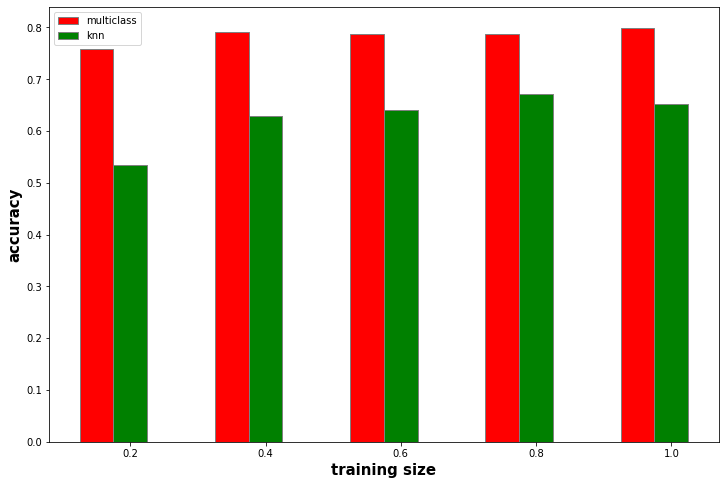

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
 
# Set position of bar on X axis
br1 = np.arange(len(split_rate))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, multiclass_list, color ='r', width = barWidth,
        edgecolor ='grey', label ='multiclass')
plt.bar(br2, KNN_list, color ='g', width = barWidth,
        edgecolor ='grey', label ='knn')
 
# Adding Xticks
plt.xlabel('training size', fontweight ='bold', fontsize = 15)
plt.ylabel('accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(split_rate))],
        ['0.2', '0.4', '0.6', '0.8', '1.0'])
 
plt.legend()
plt.show()